# PyTorch scaling benchmark analysis

Throughput scaling of PyTorch benchmarks on Cori Haswell with PyTorch distributed and Cray MPI.

In [1]:
import os
import re
import glob

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Utilities

In [4]:
def plot_scaling(ranks, rates, title=None, loglog=False):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Compute ideal scaling relative to lowest rank
    ideal_rates = rates[0] * ranks / ranks[0]

    # Plot throughput scaling
    ax0.plot(ranks, rates, '.-', ms=15, label='measured')
    ax0.plot(ranks, ideal_rates, '--', label='ideal')
    ax0.set_xlabel('Number of workers')
    ax0.set_ylabel('Training throughput [samples/s]')
    if loglog:
        ax0.set_xscale('log')
        ax0.set_yscale('log')
    else:
        ax0.set_ylim(bottom=0)
    ax0.grid()
    ax0.legend(loc=0)

    # Plot the fraction of ideal scaling
    ax1.plot(ranks, rates / ideal_rates, '.-', ms=15)
    ax1.set_xlabel('Number of workers')
    ax1.set_ylabel('Fraction of ideal scaling')
    ax1.grid()
    ax1.set_ylim(bottom=0)
    
    if title is not None:
        ax0.set_title(title)
        ax1.set_title(title)

    plt.tight_layout()
    return fig, ax0, ax1

## Load the results data

In [5]:
ls /global/cscratch1/sd/sfarrell/pytorch-benchmarks/results

gpu-v1.5.0-nccl-n1/   gpu-v1.5.0-nccl-n8/   hsw-v1.5.0-mpi-n4/
gpu-v1.5.0-nccl-n16/  hsw-v1.5.0-mpi-n1/    hsw-v1.5.0-mpi-n64/
gpu-v1.5.0-nccl-n2/   hsw-v1.5.0-mpi-n128/  hsw-v1.5.0-mpi-n8/
gpu-v1.5.0-nccl-n32/  hsw-v1.5.0-mpi-n16/   knl-v1.5.0-mpi-n1/
gpu-v1.5.0-nccl-n4/   hsw-v1.5.0-mpi-n2/
gpu-v1.5.0-nccl-n64/  hsw-v1.5.0-mpi-n32/


In [6]:
results_files = glob.glob('/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n*/results.txt')

results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n64/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n32/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n16/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n2/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n4/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-v1.5.0-nccl-n8/results.txt']

In [7]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

results

,train_rate,inference_rate,ranks,hardware,version,backend,model
0,348426.351147,862659.209822,64,gpu,v1.5.0,nccl,lstm
1,30241.394919,142851.227840,64,gpu,v1.5.0,nccl,alexnet
2,15514.592661,53096.953395,64,gpu,v1.5.0,nccl,resnet50
3,86023.588910,536090.601718,64,gpu,v1.5.0,nccl,cnn3d
4,180596.038700,429261.598196,32,gpu,v1.5.0,nccl,lstm
5,14520.568075,69266.451109,32,gpu,v1.5.0,nccl,alexnet
6,8213.325266,26613.581344,32,gpu,v1.5.0,nccl,resnet50
7,44554.871030,268499.969372,32,gpu,v1.5.0,nccl,cnn3d
8,100591.302036,215691.193763,16,gpu,v1.5.0,nccl,lstm
9,8071.667213,35836.695264,16,gpu,v1.5.0,nccl,alexnet


## Training throughput scaling

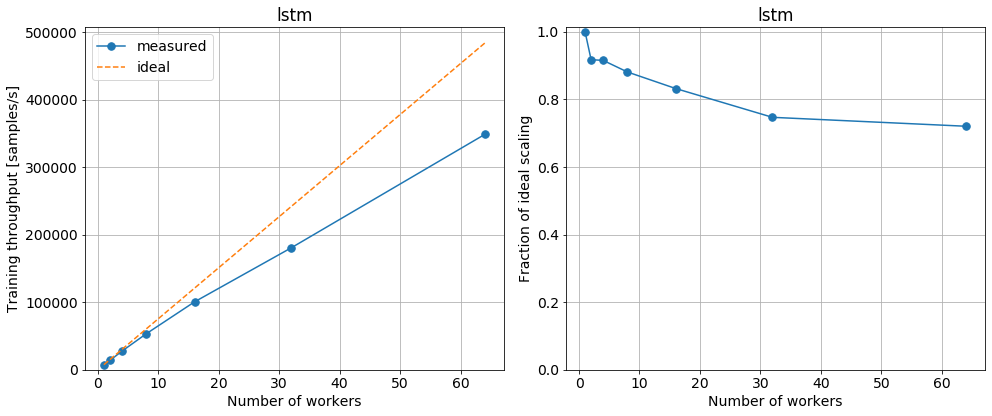

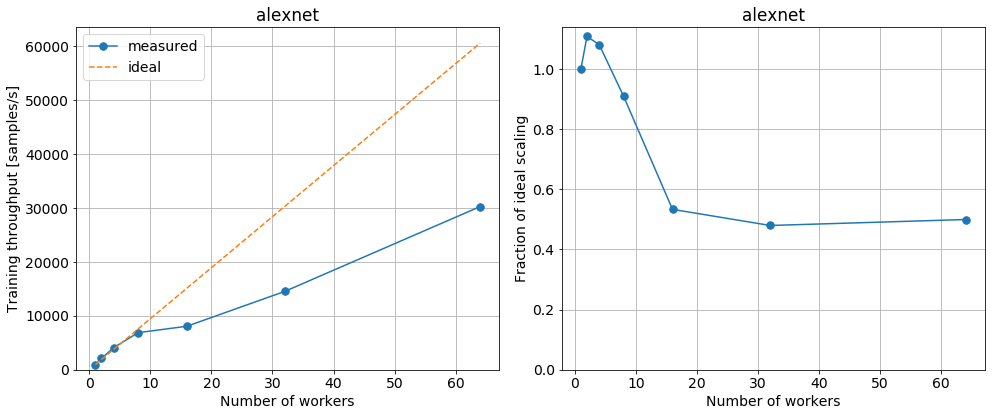

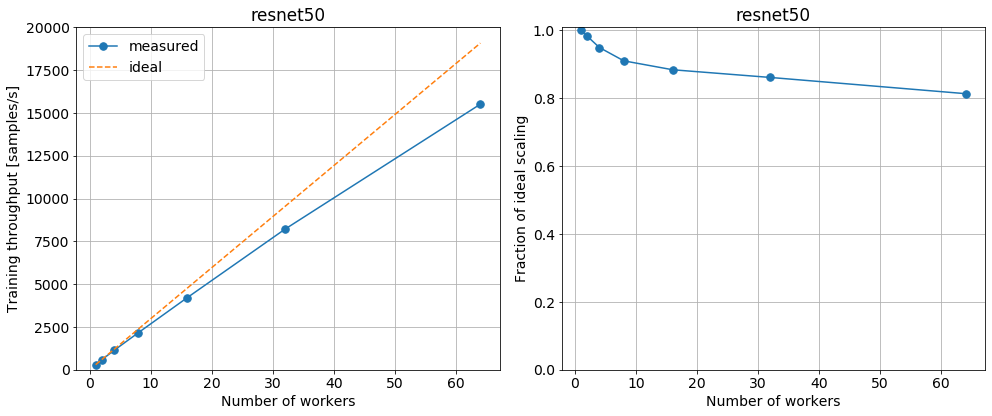

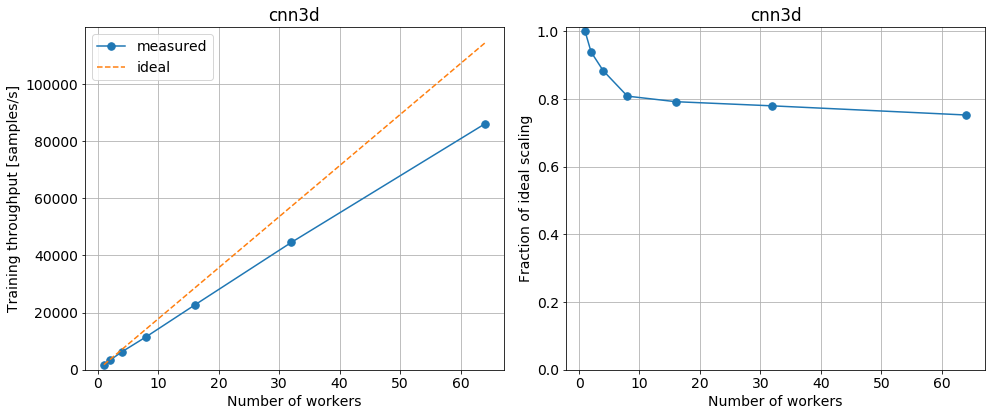

In [8]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.train_rate.values,
                                 title=model)

## Inference throughput scaling

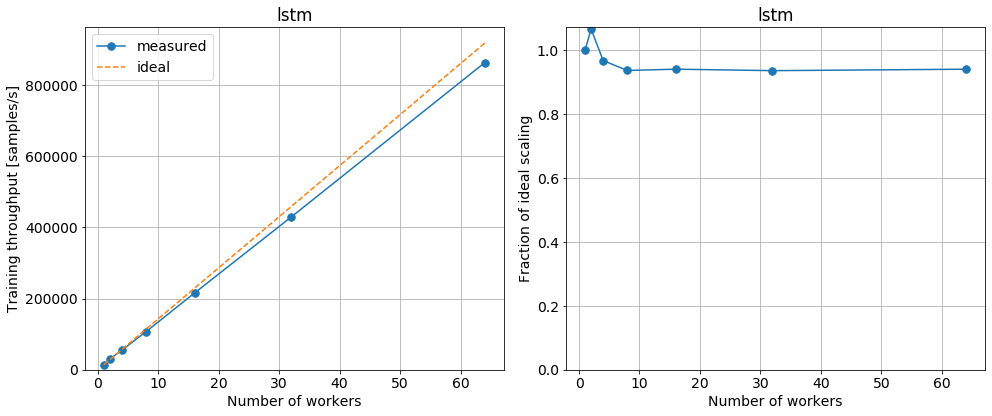

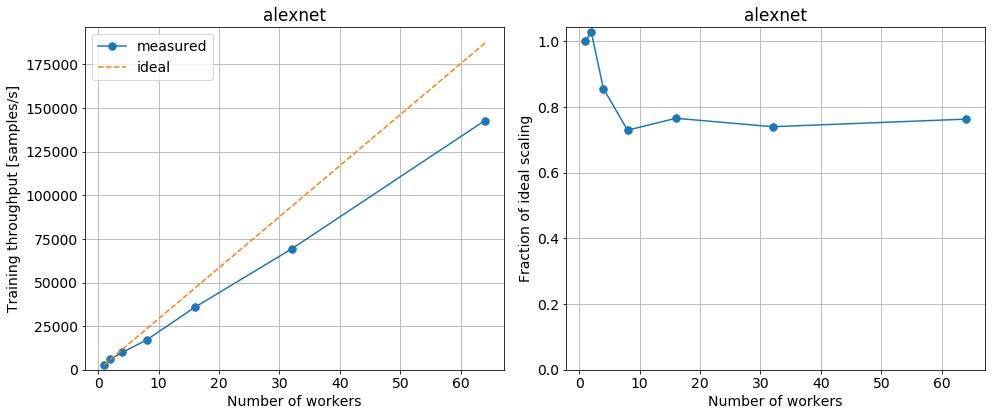

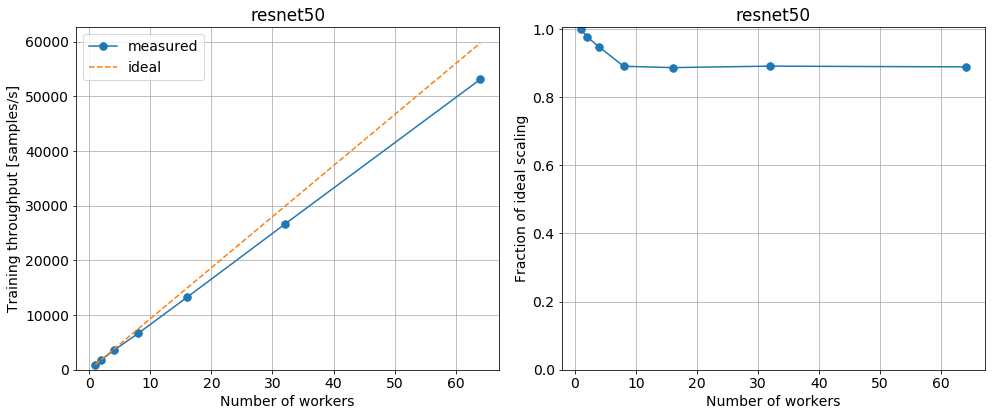

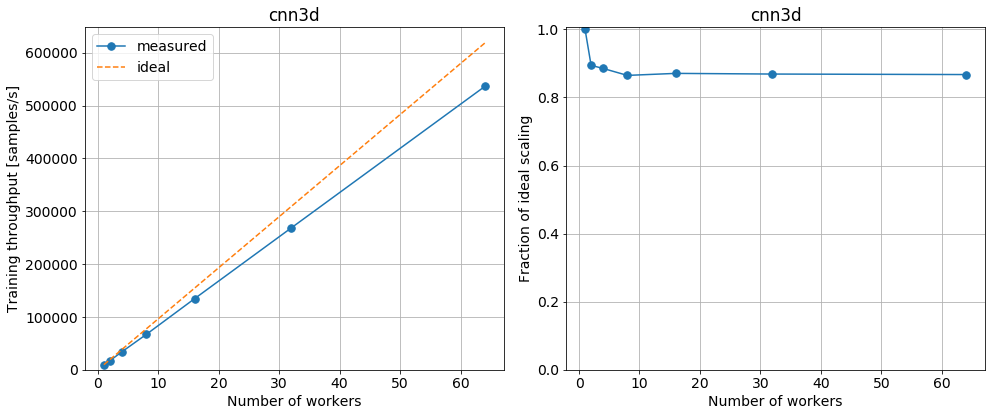

In [9]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.inference_rate.values,
                                 title=model)